<a href="https://colab.research.google.com/github/shimo23333/CLIP-ColorCulture/blob/main/%E6%96%B0_%E8%B7%A8%E6%96%87%E5%8C%96%E8%89%B2%E5%BD%A9%E8%AA%9E%E6%84%8F%E6%AF%94%E8%BC%83_CLIP%E4%B8%AD%E8%AA%9E%E8%A8%80%E5%B0%8D%E8%89%B2%E5%BD%A9%E7%90%86%E8%A7%A3%E7%9A%84%E5%B7%AE%E7%95%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1:安裝必要的 Python 套件

!pip install -q git+https://github.com/openai/CLIP.git
!pip install -q googletrans==4.0.0rc1
!pip install -q scikit-image
!pip install -q opencv-python # 圖像分析
!pip install -q diffusers transformers accelerate invisible-watermark safetensors
!pip install -q ipywidgets

print("1:安裝完成。")

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 792.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 62.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import torch
import clip
from PIL import Image, ImageDraw, ImageFont
from googletrans import Translator
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from skimage.color import rgb2lab
import cv2
from diffusers import StableDiffusionPipeline
import os
from sklearn.metrics.pairwise import cosine_similarity
from tqdm.notebook import tqdm
import time
# import textwrap # textwrap 在原腳本中沒有被使用，移除
import matplotlib.font_manager as fm

print("2:函式庫匯入完成。")

2:函式庫匯入完成。


In [3]:
class ConfigManager:
    """
    職責：管理設定，如運算設備、字體路徑和輸出目錄。
    說明：這就像是專案的「設定面板」，集中管理一些全域會用到的設定值。
    """
    def __init__(self, font_path_cjk='/usr/share/fonts/opentype/noto/NotoSansCJKjp-Regular.otf',
                 images_out_dir="project_outputs_final_v4_oop"):
        self.device = self._get_device()
        self.font_path_cjk = font_path_cjk
        self.images_out_dir = images_out_dir
        self._setup_matplotlib_font()
        self._setup_output_directory()

    def _get_device(self):
        device = "cuda" if torch.cuda.is_available() else "cpu"
        print(f"4:本次運行的計算設備是: {device}")
        if device == "cpu":
            print("警告：未使用GPU！運行大型AI模型會非常慢。")
        return device

    def _setup_matplotlib_font(self):
        print("3:正在設定 Matplotlib CJK 字體...")
        if os.path.exists(self.font_path_cjk):
            try:
                fm.fontManager.addfont(self.font_path_cjk)
                prop = fm.FontProperties(fname=self.font_path_cjk)
                font_name = prop.get_name()
                plt.rcParams['font.family'] = font_name
                plt.rcParams['axes.unicode_minus'] = False
                print(f"  已成功設定 CJK 字體為: {font_name}")
            except Exception as e:
                print(f"  設定字體 '{self.font_path_cjk}' 時發生錯誤: {e}. 退到通用列表。")
                plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'SimHei', 'sans-serif']
        else:
            print(f"  指定的 CJK 字體文件路徑不存在: {self.font_path_cjk}. 退到通用列表。")
            plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'SimHei', 'sans-serif']
        plt.rcParams['axes.unicode_minus'] = False # 確保這行在通用列表後也執行
        print("3:Matplotlib CJK 字體設定完畢。")

    def _setup_output_directory(self):
        if not os.path.exists(self.images_out_dir):
            os.makedirs(self.images_out_dir)
            print(f"  已建立圖像儲存目錄: {self.images_out_dir}")


In [4]:
class ModelManager:
    """
    職責：載入和管理AI模型 (CLIP, Stable Diffusion)。
    說明：這就像是專案的「AI模型倉庫管理員」，負責把需要的模型準備好，並在結束時清理。
    """
    def __init__(self, device):
        self.device = device
        self.clip_model = None
        self.clip_preprocess = None
        self.sd_pipeline = None
        self.translator = None

    def load_clip_model(self, model_name="ViT-B/32"):
        print(f"5:準備載入 CLIP 模型 ({model_name})...")
        if self.device == "cuda":
            try:
                self.clip_model, self.clip_preprocess = clip.load(model_name, device=self.device)
                self.clip_model.eval()
                print(f"  CLIP 模型 ({model_name}) 已成功載入到 {self.device}！")
                torch.cuda.empty_cache()
            except Exception as e:
                print(f"  載入CLIP模型時發生錯誤: {e}")
        else:
            print(f"  未實際載入CLIP模型，因為當前運算設備是 {self.device}。")
        return self.clip_model, self.clip_preprocess

    def load_sd_model(self, model_id="runwayml/stable-diffusion-v1-5"):
        print(f"6:準備載入 Stable Diffusion 模型 ({model_id})...")
        if self.device == "cuda":
            try:
                self.sd_pipeline = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
                self.sd_pipeline = self.sd_pipeline.to(self.device)
                print(f"  Stable Diffusion 模型 ({model_id}) 已成功載入到 {self.device}！")
                torch.cuda.empty_cache()
            except Exception as e:
                print(f"  載入Stable Diffusion模型時發生錯誤: {e}")
        else:
            print(f"  未實際載入Stable Diffusion模型，因為當前運算設備是 {self.device}。")
        return self.sd_pipeline

    def init_translator(self):
        print("7:正在初始化 Google 翻譯工具...")
        try:
            self.translator = Translator()
            test_text = "你好"
            translated_test_text = self.translator.translate(test_text, src='zh-cn', dest='en').text
            print(f"  Google 翻譯工具初始化成功！測試翻譯 '{test_text}' -> '{translated_test_text}'")
        except Exception as e:
            print(f"  Google 翻譯工具初始化失敗: {e}")
        return self.translator

    def cleanup(self):
        print("正在清理模型資源...")
        if self.clip_model: del self.clip_model
        if self.clip_preprocess: del self.clip_preprocess
        if self.sd_pipeline: del self.sd_pipeline
        if self.translator: del self.translator
        if self.device == "cuda":
            torch.cuda.empty_cache()
        print("  模型和資源清理操作已執行。")


In [5]:
class ConceptDataProvider:
    """
    職責：提供專案要分析的詞彙概念及多語言翻譯。
    說明：這就像是專案的「詞彙字典」，存放著所有要研究的詞和它們的翻譯。
    """
    def __init__(self):
        self.word_concepts_list = [
            {"concept_name": "cool_ambiguous", "base_chinese": "酷 / 涼爽", "translations":
                {"zh": "冰涼的飲料，酷炫的風格，冷靜的態度",
                 "en": "cool refreshing drink, cool stylish look, calm and cool attitude",
                 "ja": "冷たい飲み物、かっこいいスタイル、冷静な態度",
                 "ko": "시원한 음료, 멋진 스타일, 침착한 태도"}},
            # ... (保留所有詞彙定義) ...
            {"concept_name": "tired_clear", "base_chinese": "疲憊", "translations":
                {"zh": "長時間工作後感到身心疲憊，舒適柔軟的床鋪",
                 "en": "feeling mentally and physically exhausted after long hours of work, a comfortable and soft bed",
                 "ja": "長時間の仕事の後で心身ともに疲れ果てた、快適で柔らかいベッド",
                 "ko": "장시간 작업 후 심신이 지친 상태, 편안하고 부드러운 침대"}},
        ]
        # self.word_concepts_to_process = [self.word_concepts_list[0], self.word_concepts_list[2]] # 測試用
        self.word_concepts_to_process = self.word_concepts_list
        print(f"8:定義了 {len(self.word_concepts_to_process)} 個詞彙概念用於本次分析。")

    def get_concepts_to_process(self):
        return self.word_concepts_to_process


In [6]:
class TextAnalyzer:
    """
    職責：處理文本，如獲取CLIP嵌入向量和計算相似度。
    說明：這就像是專案的「文本分析師」，專門理解文字的意義並比較它們的相似程度。
    """
    def __init__(self, clip_model, device):
        self.clip_model = clip_model
        self.device = device

    def get_clip_text_embeddings(self, text_prompts_dict):
        # print("9:定義完成。 (get_clip_text_embeddings_vector)") # 移至方法內
        if self.clip_model is None:
            # 返回與模型輸出維度匹配的零向量 (CLIP ViT-B/32輸出512維)
            return {lang_code: np.zeros(512, dtype=np.float32) for lang_code in text_prompts_dict}

        text_embeddings_result_dict = {}
        with torch.no_grad():
            for lang_tag, text_content in text_prompts_dict.items():
                try:
                    tokenized_input_text = clip.tokenize([text_content]).to(self.device)
                    text_semantic_features = self.clip_model.encode_text(tokenized_input_text)
                    text_semantic_features /= text_semantic_features.norm(dim=-1, keepdim=True)
                    text_embeddings_result_dict[lang_tag] = text_semantic_features.cpu().numpy().flatten()
                except Exception as e:
                    print(f"為 '{lang_tag}':'{text_content[:30]}...' 生成CLIP嵌入時出錯: {e}")
                    text_embeddings_result_dict[lang_tag] = np.zeros(512, dtype=np.float32) # 確保錯誤時返回正確形狀的零向量
        return text_embeddings_result_dict

    def calculate_embedding_similarity(self, embeddings_dict, reference_lang='en'):
        # print("10:定義完成。 (calculate_and_print_embedding_similarity)") # 移至方法內
        similarity_scores_result = {}
        # 檢查參考語言的嵌入是否存在且不全為零
        if reference_lang not in embeddings_dict or np.all(np.isclose(embeddings_dict[reference_lang], 0)):
            print(f"  參考語言 '{reference_lang.upper()}' 的嵌入向量無效或不存在，無法計算相似度。")
            return {f"{reference_lang}_vs_{lang}": None for lang in embeddings_dict if lang != reference_lang}

        print(f"  CLIP文本嵌入向量餘弦相似度 (vs '{reference_lang.upper()}'):")
        ref_embedding = embeddings_dict[reference_lang].reshape(1, -1)

        for lang, emb in embeddings_dict.items():
            if lang == reference_lang:
                continue

            sim_val_str = "N/A (嵌入無效)"
            sim_num = None
            if not np.all(np.isclose(emb, 0)): # 檢查當前語言的嵌入是否有效
                sim_num = cosine_similarity(ref_embedding, emb.reshape(1, -1))[0][0]
                sim_val_str = f"{sim_num:.3f}"

            similarity_scores_result[f"{reference_lang}_vs_{lang}"] = sim_num
            print(f"    - 與 {lang.upper()}: {sim_val_str}")
        return similarity_scores_result


In [7]:
class ImageProcessor:
    """
    職責：處理圖像，如生成圖像、提取顏色、分析全局特徵。
    說明：這就像是專案的「圖像處理大師」，會畫圖，也會分析圖的顏色和整體感覺。
    """
    def __init__(self, sd_pipeline, device):
        self.sd_pipeline = sd_pipeline
        self.device = device

    def generate_image_with_sd(self, prompt_text, random_seed=42, inference_steps=30, cfg_scale=7.5):
        # print("11:定義完成。 (generate_actual_image_with_sd)") # 移至方法內
        if self.sd_pipeline is None:
            placeholder_img = Image.new('RGB', (512, 512), color='silver')
            draw = ImageDraw.Draw(placeholder_img)
            try:
                font = ImageFont.truetype("DejaVuSans.ttf", 18)
            except IOError: # 更具體的異常
                font = ImageFont.load_default()
            draw.text((10, 10), f"模型未載入\n提示:\n{prompt_text[:70]}...", fill=(60, 60, 60), font=font)
            return placeholder_img
        try:
            gen = torch.Generator(device=self.device).manual_seed(random_seed)
            with torch.no_grad():
                img = self.sd_pipeline(prompt_text, num_inference_steps=inference_steps, guidance_scale=cfg_scale, generator=gen).images[0]
            return img
        except Exception as e:
            print(f"  生成圖像時出錯 ('{prompt_text[:40]}...'): {e}")
            error_img = Image.new('RGB', (512, 512), color='lightcoral')
            draw = ImageDraw.Draw(error_img)
            try:
                font = ImageFont.truetype("DejaVuSans.ttf", 15)
            except IOError:
                font = ImageFont.load_default()
            draw.text((10, 10), f"圖像生成錯誤:\n{prompt_text[:60]}...\n錯誤:\n{str(e)[:100]}", fill=(0, 0, 0), font=font)
            return error_img

    def extract_dominant_colors(self, pil_img, num_colors=5):
        # print("12:定義完成。 (extract_dominant_colors_from_image)") # 移至方法內
        if pil_img is None or pil_img.width < num_colors or pil_img.height < num_colors: # 基本檢查
            rgb_fallback = np.array([[128, 128, 128]] * num_colors, dtype=int)
            lab_fallback = rgb2lab(rgb_fallback / 255.0).reshape(-1, 3)
            return rgb_fallback, lab_fallback
        try:
            img_rgb = pil_img.convert('RGB')
            max_dim = 150 # 縮小圖像以加快KMeans
            ratio = max_dim / max(img_rgb.width, img_rgb.height)
            new_size = (max(1, int(img_rgb.width * ratio)), max(1, int(img_rgb.height * ratio)))
            img_res = img_rgb.resize(new_size, Image.Resampling.LANCZOS)
            pixels = np.array(img_res).reshape(-1, 3)

            if pixels.shape[0] < num_colors: # 如果像素總數少於要提取的顏色數
                rgb_colors = np.zeros((num_colors, 3), dtype=int)
                actual_extracted_colors = pixels.astype(int)
                rgb_colors[:actual_extracted_colors.shape[0]] = actual_extracted_colors
                # 用灰色填充剩餘的顏色槽
                if actual_extracted_colors.shape[0] < num_colors:
                    rgb_colors[actual_extracted_colors.shape[0]:] = np.array([128,128,128])
            else:
                kmeans = KMeans(n_clusters=num_colors, random_state=0, n_init='auto', max_iter=200).fit(pixels)
                rgb_colors = kmeans.cluster_centers_.astype(int)

            lab_colors = rgb2lab(rgb_colors.reshape((num_colors, 1, 3)) / 255.0).reshape((num_colors, 3))
            return rgb_colors, lab_colors
        except Exception as e:
            print(f"  提取主色調時出錯: {e}")
            rgb_err = np.array([[100, 100, 100]] * num_colors, dtype=int)
            lab_err = rgb2lab(rgb_err / 255.0).reshape(-1, 3)
            return rgb_err, lab_err


    def analyze_global_features(self, pil_image):
        # print("13:定義完成。 (analyze_global_image_features)") # 移至方法內
        if pil_image is None:
            return {"avg_brightness": "N/A", "contrast_std": "N/A", "avg_saturation": "N/A"}
        try:
            cv_bgr = np.array(pil_image.convert('RGB'))[:, :, ::-1].copy() # PIL RGB to OpenCV BGR
            gray = cv2.cvtColor(cv_bgr, cv2.COLOR_BGR2GRAY)
            brightness = round(np.mean(gray), 2)
            contrast = round(np.std(gray), 2)

            hsv = cv2.cvtColor(cv_bgr, cv2.COLOR_BGR2HSV)
            saturation = round(np.mean(hsv[:, :, 1]), 2) # Saturation is in H S V
            return {"avg_brightness": brightness, "contrast_std": contrast, "avg_saturation": saturation}
        except Exception as e:
            print(f"  分析全局圖像特徵時出錯: {e}")
            return {"avg_brightness": "Err", "contrast_std": "Err", "avg_saturation": "Err"}


In [8]:
class ReportGenerator:
    """
    職責：產生分析報告和繪製結果圖表。
    說明：這就像是專案的「報告撰寫員與設計師」，負責整理結果並用圖表展示。
    """
    def generate_explanation_template(self, chinese_concept, lang_prompt_info, dom_colors_hex=None, global_feats=None):
        # print("14:定義完成。 (generate_explanation_for_image)") # 移至方法內
        expl = f"\n--- 解釋模板 for 概念:【{chinese_concept}】| 語言提示: 【{lang_prompt_info[:70]}...】 ---\n"
        if dom_colors_hex:
            expl += f"圖像主要色票 (HEX): {', '.join(dom_colors_hex[:3])} ...\n"
        if global_feats:
            expl += f"全局圖像特徵: 亮度={global_feats.get('avg_brightness', 'N/A')}, "
            expl += f"對比度={global_feats.get('contrast_std', 'N/A')}, 飽和度={global_feats.get('avg_saturation', 'N/A')}\n"
        expl += f"\n原因推測與圖像描述 (請您填充)：\n"
        expl += f"   [請結合以上客觀指標和您的觀察，詳細闡述：\n"
        expl += f"    a. 圖像視覺風格與氛圍？\n"
        expl += f"    b. 主要元素與提示詞的關聯？\n"
        expl += f"    c. 色彩運用如何詮釋提示詞？\n"
        expl += f"    d. (特定語言)文化背景的可能影響？(例如韓國圖像為何常出現人物?)\n"
        expl += f"    e. 與其他語言生成圖像的差異及可能原因？]\n"
        expl += f"--------------------------------------------------------------------------\n"
        return expl

    def plot_concept_results(self, concept_id, base_chinese, prompts_dict, images_dict,
                               colors_dict, similarities_dict, global_features_dict=None):
        # print("Cell 14: 輔助函式 `plot_full_concept_results_chart` 定義完成。") # 移至方法內
        langs = list(prompts_dict.keys())
        num_langs = len(langs)
        if num_langs == 0: return # 無語言可繪製

        h_ratio, w_ratio = 2.8, 4.0
        total_h, total_w = h_ratio * 2, w_ratio * num_langs
        fig, axs = plt.subplots(2, num_langs, figsize=(total_w, total_h), gridspec_kw={'height_ratios': [0.78, 0.22]})

        if num_langs == 1: # plt.subplots返回的axs形狀問題
            axs = axs.reshape(2, 1)

        title_base = f"概念分析: '{base_chinese}' ({concept_id})\nCLIP相似度(vs EN): "
        sim_strs = []
        if similarities_dict: # 確保 similarities_dict 不是 None
            sim_strs = [f"{k.split('_vs_')[-1].upper()}: {v:.2f}" if isinstance(v, (float, np.floating)) else f"{k.split('_vs_')[-1].upper()}: {v}"
                        for k, v in similarities_dict.items()]
        fig.suptitle(title_base + ", ".join(sim_strs), fontsize=11, y=1.04)

        for i, lang in enumerate(langs):
            img = images_dict.get(lang)
            colors_data = colors_dict.get(lang) # (rgb_patch, lab_patch)
            global_feats_this_lang = (global_features_dict or {}).get(lang, {})


            ax_img = axs[0, i]
            ax_color = axs[1, i]

            if img:
                ax_img.imshow(img)
            else:
                ax_img.text(0.5, 0.5, '圖像未生成', ha='center', va='center', transform=ax_img.transAxes)

            img_title_prompt = prompts_dict.get(lang, "N/A")
            img_title = f"{lang.upper()}: \"{img_title_prompt[:30]}\"..."
            if global_feats_this_lang:
                img_title += f"\n亮:{global_feats_this_lang.get('avg_brightness', '-')} "
                img_title += f"對比:{global_feats_this_lang.get('contrast_std', '-')} "
                img_title += f"飽:{global_feats_this_lang.get('avg_saturation', '-')}"
            ax_img.set_title(img_title, fontsize=7.5)
            ax_img.axis('off')

            if colors_data:
                rgb_patch, lab_patch = colors_data
                n_patch = len(rgb_patch)
                if n_patch > 0:
                    patch_canvas = np.zeros((25, 100, 3), dtype=np.uint8)
                    patch_w = 100 // n_patch
                    for j, rgb_c in enumerate(rgb_patch):
                        patch_canvas[:, j * patch_w:(j + 1) * patch_w] = rgb_c
                    ax_color.imshow(patch_canvas)

                    lab_str_parts = []
                    for l_val, a_val, b_val in lab_patch[:min(3,n_patch)]:
                        lab_str_parts.append(f"L{l_val:.0f} a{a_val:.0f} b{b_val:.0f}")
                    lab_str = "\n".join(lab_str_parts)
                    ax_color.set_title(f"Lab(Top{min(3,n_patch)}):\n{lab_str}", fontsize=6)
                else:
                    ax_color.text(0.5,0.5,'無顏色數據',ha='center',va='center',transform=ax_color.transAxes, fontsize=6)

            else:
                ax_color.text(0.5, 0.5, '無顏色', ha='center', va='center', transform=ax_color.transAxes, fontsize=6)
            ax_color.axis('off')

        plt.tight_layout(rect=[0, 0, 1, 0.94])
        plt.subplots_adjust(hspace=0.5, wspace=0.3)
        plt.show()


In [9]:
class AnalysisPipeline:
    """
    職責：協調所有組件，執行完整的分析流程。
    說明：這就像是專案的「總指揮」，負責調度各個專家（其他類別）按順序完成工作。
    """
    def __init__(self, config_manager, model_manager, concept_provider,
                 text_analyzer, image_processor, report_generator):
        self.config = config_manager
        self.models = model_manager
        self.concepts_provider = concept_provider
        self.text_analyzer = text_analyzer
        self.image_processor = image_processor
        self.reporter = report_generator

        # 主流程中的參數
        self.base_seed = 20240101
        self.sd_steps = 22
        self.sd_cfg = 7.0
        self.num_dom_colors = 5
        self.save_images_flag = True

    def run_analysis(self):
        print(f"Cell 15: 即將開始執行主流程...")
        concepts_to_process = self.concepts_provider.get_concepts_to_process()
        print(f"  處理 {len(concepts_to_process)} 個詞彙概念...")

        results_collection = []

        for concept_idx, concept_detail in enumerate(tqdm(concepts_to_process, desc="總體概念處理")):
            concept_id = concept_detail["concept_name"]
            base_zh = concept_detail["base_chinese"]
            prompts = concept_detail["translations"]
            print(f"\n\n處理概念 #{concept_idx + 1}: '{base_zh}' ({concept_id})")

            print("  [1. CLIP嵌入分析]")
            embeddings = self.text_analyzer.get_clip_text_embeddings(prompts)
            similarities = self.text_analyzer.calculate_embedding_similarity(embeddings, reference_lang='en')

            print("  [2. 圖像生成、顏色與全局特徵分析]")
            concept_images = {}
            concept_colors = {}
            concept_global_features = {}
            concept_explanations_str = ""

            for lang_idx, (lang, prompt) in enumerate(tqdm(prompts.items(), desc=f"  '{concept_id}'語言處理", leave=False)):
                print(f"    -> {lang.upper()}: '{prompt}'")
                img_seed = self.base_seed + concept_idx * 100 + lang_idx * 10

                pil_img = self.image_processor.generate_image_with_sd(
                    prompt,
                    random_seed=img_seed,
                    inference_steps=self.sd_steps,
                    cfg_scale=self.sd_cfg
                )
                concept_images[lang] = pil_img

                if self.save_images_flag and pil_img:
                    try:
                        fname = f"{concept_id}_{lang}_s{img_seed}.png"
                        fpath = os.path.join(self.config.images_out_dir, fname)
                        pil_img.save(fpath)
                    except Exception as e:
                        print(f"      儲存圖像'{fname}'失敗: {e}")

                rgb_cs, lab_cs = self.image_processor.extract_dominant_colors(pil_img, self.num_dom_colors)
                concept_colors[lang] = (rgb_cs, lab_cs)

                global_feats = self.image_processor.analyze_global_features(pil_img)
                concept_global_features[lang] = global_feats

                hex_colors = [f"#{c[0]:02x}{c[1]:02x}{c[2]:02x}" for c in rgb_cs] if rgb_cs is not None else []
                expl_text = self.reporter.generate_explanation_template(
                    base_zh, f"{lang.upper()}: {prompt}", hex_colors, global_feats
                )
                print(expl_text) # 打印每個語言的解釋模板
                concept_explanations_str += expl_text

                if self.config.device == "cuda":
                    torch.cuda.empty_cache()
                    time.sleep(0.05) # 短暫停頓

            print("\n  [3. 繪製結果圖表]")
            self.reporter.plot_concept_results(
                concept_id, base_zh, prompts, concept_images,
                concept_colors, similarities, concept_global_features
            )

            results_collection.append({
                "concept": concept_id,
                "base_chinese": base_zh,
                "prompts": prompts,
                "similarities": similarities,
                "global_features": concept_global_features,
                "explanation_prompts_combined": concept_explanations_str # 組合的解釋模板
            })
            print(f"  概念 '{concept_id}' 分析完畢。")
            if self.config.device == "cuda":
                torch.cuda.empty_cache()

        print("\n\n所有詞彙概念處理完成！解釋模板已在上方打印。")
        # 可選: 保存 results_collection (這裡省略，但可以添加)
        return results_collection


4:本次運行的計算設備是: cpu
警告：未使用GPU！運行大型AI模型會非常慢。
3:正在設定 Matplotlib CJK 字體...
  指定的 CJK 字體文件路徑不存在: /usr/share/fonts/opentype/noto/NotoSansCJKjp-Regular.otf. 退到通用列表。
3:Matplotlib CJK 字體設定完畢。
  已建立圖像儲存目錄: project_outputs_final_v4_oop
5:準備載入 CLIP 模型 (ViT-B/32)...
  未實際載入CLIP模型，因為當前運算設備是 cpu。
6:準備載入 Stable Diffusion 模型 (runwayml/stable-diffusion-v1-5)...
  未實際載入Stable Diffusion模型，因為當前運算設備是 cpu。
8:定義了 2 個詞彙概念用於本次分析。
Cell 15: 即將開始執行主流程...
  處理 2 個詞彙概念...


總體概念處理:   0%|          | 0/2 [00:00<?, ?it/s]



處理概念 #1: '酷 / 涼爽' (cool_ambiguous)
  [1. CLIP嵌入分析]
  參考語言 'EN' 的嵌入向量無效或不存在，無法計算相似度。
  [2. 圖像生成、顏色與全局特徵分析]


  'cool_ambiguous'語言處理:   0%|          | 0/4 [00:00<?, ?it/s]

    -> ZH: '冰涼的飲料，酷炫的風格，冷靜的態度'

--- 解釋模板 for 概念:【酷 / 涼爽】| 語言提示: 【ZH: 冰涼的飲料，酷炫的風格，冷靜的態度...】 ---
圖像主要色票 (HEX): #c0c0c0, #828282, #b0b0b0 ...
全局圖像特徵: 亮度=191.76, 對比度=4.71, 飽和度=0.0

原因推測與圖像描述 (請您填充)：
   [請結合以上客觀指標和您的觀察，詳細闡述：
    a. 圖像視覺風格與氛圍？
    b. 主要元素與提示詞的關聯？
    c. 色彩運用如何詮釋提示詞？
    d. (特定語言)文化背景的可能影響？(例如韓國圖像為何常出現人物?)
    e. 與其他語言生成圖像的差異及可能原因？]
--------------------------------------------------------------------------

    -> EN: 'cool refreshing drink, cool stylish look, calm and cool attitude'

--- 解釋模板 for 概念:【酷 / 涼爽】| 語言提示: 【EN: cool refreshing drink, cool stylish look, calm and cool attitude...】 ---
圖像主要色票 (HEX): #c0c0c0, #979797, #b7b7b7 ...
全局圖像特徵: 亮度=191.62, 對比度=6.17, 飽和度=0.0

原因推測與圖像描述 (請您填充)：
   [請結合以上客觀指標和您的觀察，詳細闡述：
    a. 圖像視覺風格與氛圍？
    b. 主要元素與提示詞的關聯？
    c. 色彩運用如何詮釋提示詞？
    d. (特定語言)文化背景的可能影響？(例如韓國圖像為何常出現人物?)
    e. 與其他語言生成圖像的差異及可能原因？]
--------------------------------------------------------------------------

    -> JA: '冷たい飲み物、かっこいいスタイル、冷静な態度'

--- 解釋模板 for 概念:【酷 / 涼爽】| 語

<ipython-input-8-a96e764ee76c>:90: UserWarning: Glyph 20912 (\N{CJK UNIFIED IDEOGRAPH-51B0}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.94])
<ipython-input-8-a96e764ee76c>:90: UserWarning: Glyph 28092 (\N{CJK UNIFIED IDEOGRAPH-6DBC}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.94])
<ipython-input-8-a96e764ee76c>:90: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.94])
<ipython-input-8-a96e764ee76c>:90: UserWarning: Glyph 39154 (\N{CJK UNIFIED IDEOGRAPH-98F2}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.94])
<ipython-input-8-a96e764ee76c>:90: UserWarning: Glyph 26009 (\N{CJK UNIFIED IDEOGRAPH-6599}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.94])
<ipython-input-8-a96e764ee76c>:90: UserWarning: Glyph 65292 (\N{FULLWIDTH COMMA}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.94])
<ip

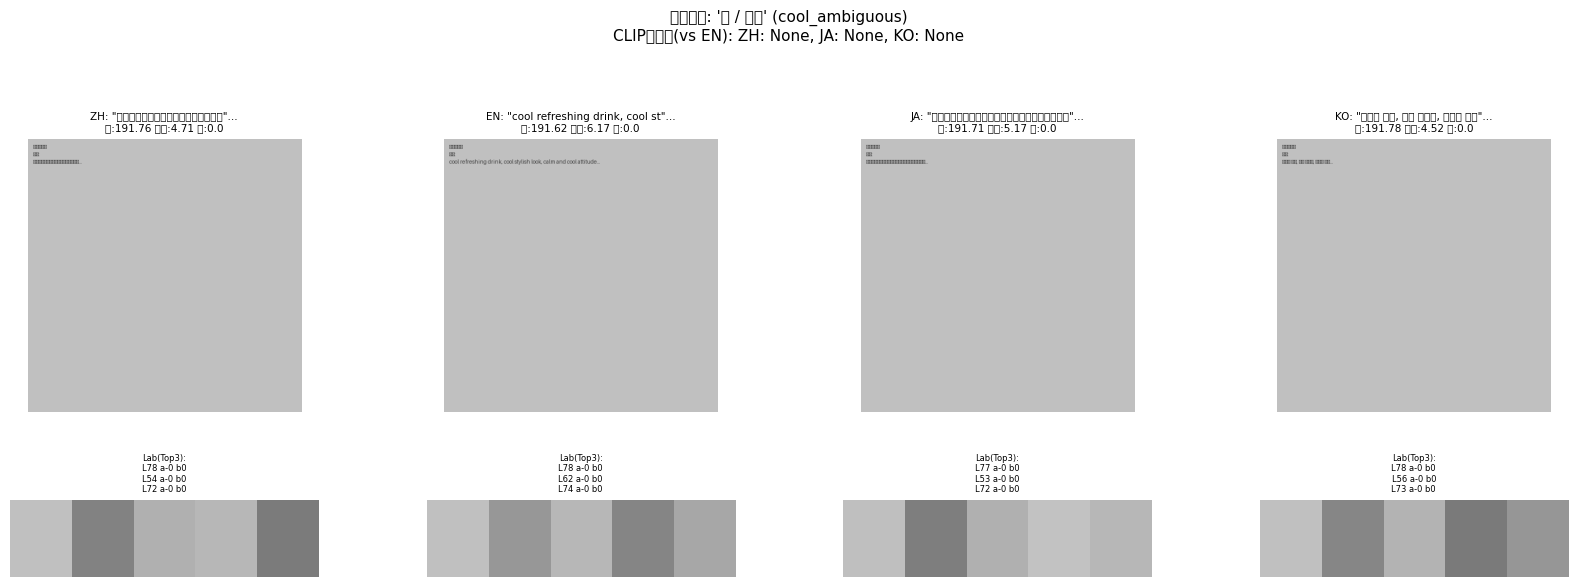

  概念 'cool_ambiguous' 分析完畢。


處理概念 #2: '疲憊' (tired_clear)
  [1. CLIP嵌入分析]
  參考語言 'EN' 的嵌入向量無效或不存在，無法計算相似度。
  [2. 圖像生成、顏色與全局特徵分析]


  'tired_clear'語言處理:   0%|          | 0/4 [00:00<?, ?it/s]

    -> ZH: '長時間工作後感到身心疲憊，舒適柔軟的床鋪'

--- 解釋模板 for 概念:【疲憊】| 語言提示: 【ZH: 長時間工作後感到身心疲憊，舒適柔軟的床鋪...】 ---
圖像主要色票 (HEX): #bfbfbf, #7e7e7e, #b0b0b0 ...
全局圖像特徵: 亮度=191.73, 對比度=4.99, 飽和度=0.0

原因推測與圖像描述 (請您填充)：
   [請結合以上客觀指標和您的觀察，詳細闡述：
    a. 圖像視覺風格與氛圍？
    b. 主要元素與提示詞的關聯？
    c. 色彩運用如何詮釋提示詞？
    d. (特定語言)文化背景的可能影響？(例如韓國圖像為何常出現人物?)
    e. 與其他語言生成圖像的差異及可能原因？]
--------------------------------------------------------------------------

    -> EN: 'feeling mentally and physically exhausted after long hours of work, a comfortable and soft bed'

--- 解釋模板 for 概念:【疲憊】| 語言提示: 【EN: feeling mentally and physically exhausted after long hours of work...】 ---
圖像主要色票 (HEX): #c0c0c0, #989898, #868686 ...
全局圖像特徵: 亮度=191.57, 對比度=6.54, 飽和度=0.0

原因推測與圖像描述 (請您填充)：
   [請結合以上客觀指標和您的觀察，詳細闡述：
    a. 圖像視覺風格與氛圍？
    b. 主要元素與提示詞的關聯？
    c. 色彩運用如何詮釋提示詞？
    d. (特定語言)文化背景的可能影響？(例如韓國圖像為何常出現人物?)
    e. 與其他語言生成圖像的差異及可能原因？]
--------------------------------------------------------------------------

    -> JA: '長時間の仕事の後で心身ともに疲れ果てた、快適

<ipython-input-8-a96e764ee76c>:90: UserWarning: Glyph 38263 (\N{CJK UNIFIED IDEOGRAPH-9577}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.94])
<ipython-input-8-a96e764ee76c>:90: UserWarning: Glyph 26178 (\N{CJK UNIFIED IDEOGRAPH-6642}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.94])
<ipython-input-8-a96e764ee76c>:90: UserWarning: Glyph 38291 (\N{CJK UNIFIED IDEOGRAPH-9593}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.94])
<ipython-input-8-a96e764ee76c>:90: UserWarning: Glyph 24037 (\N{CJK UNIFIED IDEOGRAPH-5DE5}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.94])
<ipython-input-8-a96e764ee76c>:90: UserWarning: Glyph 20316 (\N{CJK UNIFIED IDEOGRAPH-4F5C}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.94])
<ipython-input-8-a96e764ee76c>:90: UserWarning: Glyph 24460 (\N{CJK UNIFIED IDEOGRAPH-5F8C}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1,

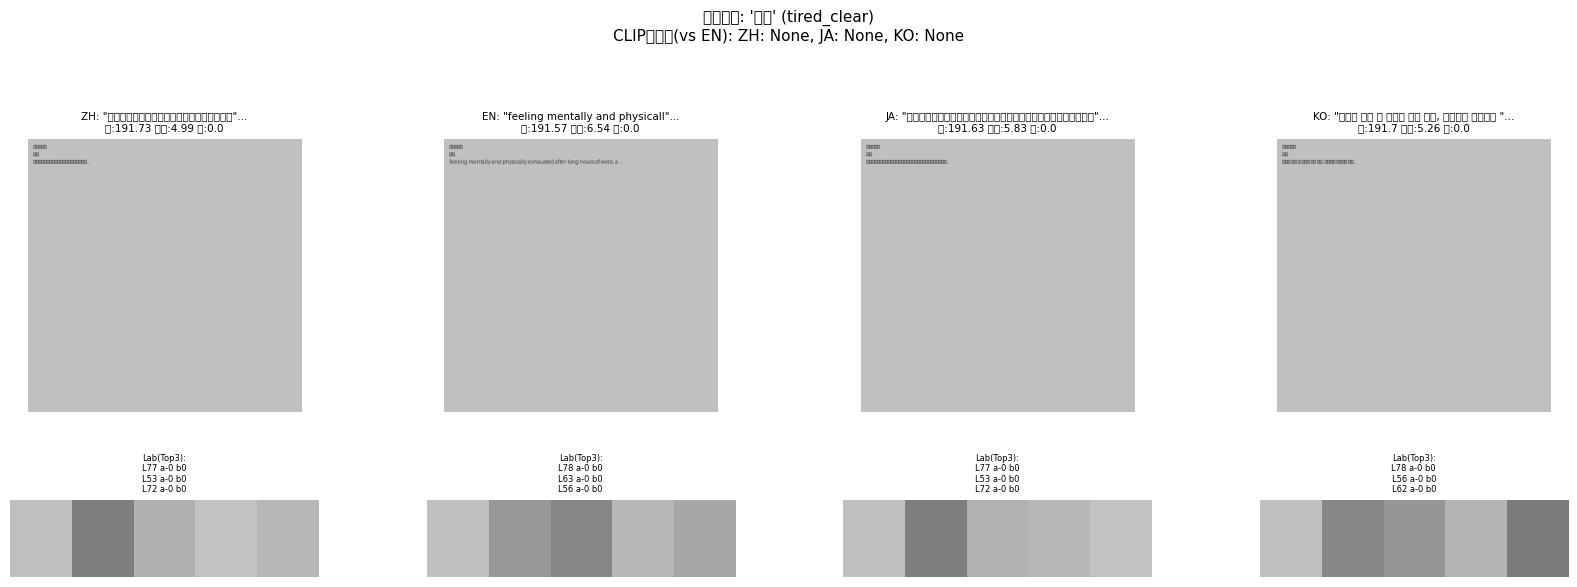

  概念 'tired_clear' 分析完畢。


所有詞彙概念處理完成！解釋模板已在上方打印。
正在清理模型資源...
  模型和資源清理操作已執行。
腳本執行完畢。


In [10]:
# --- 主執行流程 ---
if __name__ == '__main__':
    # 1. 初始化配置管理器
    config_mgr = ConfigManager()

    # 2. 初始化模型管理器
    model_mgr = ModelManager(device=config_mgr.device)
    clip_model, _ = model_mgr.load_clip_model()
    sd_pipeline = model_mgr.load_sd_model()
    # translator = model_mgr.init_translator() # 如果需要翻譯功能，取消註解

    # 3. 初始化數據和工具
    concept_provider = ConceptDataProvider()
    text_analyzer = TextAnalyzer(clip_model=clip_model, device=config_mgr.device)
    image_processor = ImageProcessor(sd_pipeline=sd_pipeline, device=config_mgr.device)
    report_generator = ReportGenerator()

    # 4. 初始化並執行分析流程
    pipeline = AnalysisPipeline(
        config_manager=config_mgr,
        model_manager=model_mgr,
        concept_provider=concept_provider,
        text_analyzer=text_analyzer,
        image_processor=image_processor,
        report_generator=report_generator
    )

    all_results = pipeline.run_analysis()

    # print("\n最終收集的結果:") # 可選，如果需要打印
    # for res in all_results:
    # print(f"Concept: {res['concept']}, Similarities: {res['similarities']}")


    # 5. 清理資源
    model_mgr.cleanup()

    print("腳本執行完畢。")